# Preparation

## Importation and setting global variables

In [62]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from imblearn.over_sampling import SMOTE

In [70]:
CSV_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/AppStats Project/data.csv'

TEST_TO_ALL_SIZE = 0.125
VAL_TO_TRAIN_SIZE = 0.1

RSPL_TO_OVER_SIZE = 2

RANDOM_STATE = 42

## Setting up

In [3]:
np.random.seed(RANDOM_STATE)

In [4]:
f2_score = lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2)
f2_scorer = make_scorer(fbeta_score, beta=2)

In [5]:
def print_and_plot_results(params, test_res_list, train_res_list):
    for index, (param, test_res, train_res) in \
            enumerate(zip(params, test_res_list, train_res_list)):
        print(f'{param}, test={test_res}, train={train_res}')

    plt.plot(params, test_res_list)
    plt.plot(params, train_res_list)

# Data preparation

## Data exploration

In [6]:
df = pd.read_csv(CSV_FILE_PATH)
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [7]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


## Splitting the dataset into training set, validation set, and test set

In [8]:
y = (df['Bankrupt?']).to_numpy()
y

array([1, 1, 1, ..., 0, 0, 0])

In [9]:
X = df.drop('Bankrupt?', axis=1, inplace=False).to_numpy()
X

array([[0.37059426, 0.42438945, 0.40574977, ..., 0.56405011, 1.        ,
        0.01646874],
       [0.46429094, 0.53821413, 0.51673002, ..., 0.57017495, 1.        ,
        0.02079431],
       [0.42607127, 0.49901875, 0.47229509, ..., 0.56370608, 1.        ,
        0.01647411],
       ...,
       [0.47272461, 0.533744  , 0.52063815, ..., 0.5651584 , 1.        ,
        0.09764874],
       [0.50626432, 0.5599106 , 0.55404465, ..., 0.56530151, 1.        ,
        0.04400945],
       [0.49305319, 0.57010467, 0.54954762, ..., 0.56516694, 1.        ,
        0.23390224]])

In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y,
        test_size=TEST_TO_ALL_SIZE, stratify=y,
        random_state=RANDOM_STATE)
print(  X_train_val.shape,
        X_test.shape,
        X_train_val.shape,
        y_test.shape
)

(5966, 95) (853, 95) (5966, 95) (853,)


In [11]:
X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=VAL_TO_TRAIN_SIZE,
        stratify=y_train_val,
        random_state=RANDOM_STATE)
print(  X_train.shape,
        X_val.shape,
        y_train.shape,
        y_val.shape
)

(5369, 95) (597, 95) (5369,) (597,)


(array([0, 1]), array([6599,  220]))
(array([0, 1]), array([5196,  173]))
(array([0, 1]), array([578,  19]))
(array([0, 1]), array([825,  28]))


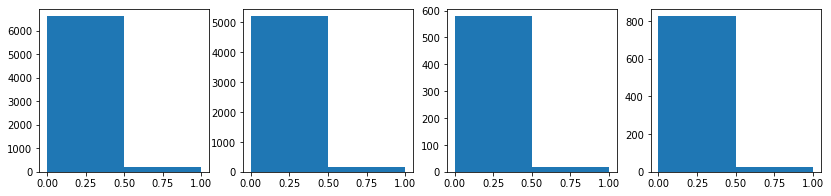

In [12]:
fig, ax = plt.subplots(1, 4)
fig.set_figheight(3)
fig.set_figwidth(14)

ax[0].hist(y, bins=2)
ax[1].hist(y_train, bins=2)
ax[2].hist(y_val, bins=2)
ax[3].hist(y_test, bins=2)

print(np.unique(y, return_counts=True))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))
print(np.unique(y_test, return_counts=True))

## Creating a new dataset that SMOTE oversample the training set

In [13]:
X_train_over, y_train_over = SMOTE(
    random_state=RANDOM_STATE).fit_resample(X_train, y_train)

(array([0, 1]), array([5196,  173]))


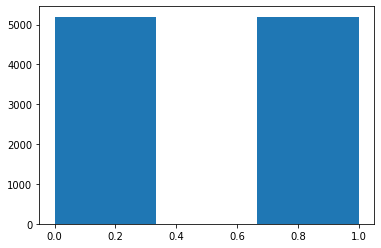

In [14]:
plt.hist(y_train_over, bins=3)
print(np.unique(y_train, return_counts=True))

## Creating a new dataset that resample the oversampled set

In [58]:
X_train_over_rspl, y_train_over_rspl = resample(
        X_train_over, y_train_over,
        stratify=y_train,
        n_samples=y_train.shape[0] * RSPL_TO_OVER_SIZE,
        random_state=RANDOM_STATE
)

# Bagging (1/2)

## Setting up parameter grid and Bagging

In [16]:
n_estimators_bagging_1 = np.unique(np.linspace(2, 20, num=5, dtype=int))
n_estimators_bagging_1

array([ 2,  6, 11, 15, 20])

In [17]:
param_grid_bagging_1 = {'n_estimators': n_estimators_bagging_1}

In [18]:
bagging_1 = BaggingClassifier(random_state=RANDOM_STATE)
bagging_1

BaggingClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [19]:
clf_bagging_1 = GridSearchCV(bagging_1, param_grid_bagging_1, scoring=f2_scorer)
clf_bagging_1

GridSearchCV(estimator=BaggingClassifier(random_state=42),
             param_grid={'n_estimators': array([ 2,  6, 11, 15, 20])},
             scoring=make_scorer(fbeta_score, beta=2))

In [20]:
clf_bagging_1.fit(X_train_over, y_train_over)

GridSearchCV(estimator=BaggingClassifier(random_state=42),
             param_grid={'n_estimators': array([ 2,  6, 11, 15, 20])},
             scoring=make_scorer(fbeta_score, beta=2))

In [21]:
clf_bagging_1.cv_results_

{'mean_fit_time': array([ 3.34504409,  7.05686851, 11.34044471, 15.49783673, 20.39303226]),
 'mean_score_time': array([0.01518855, 0.01023445, 0.01576867, 0.02157331, 0.02764444]),
 'mean_test_score': array([0.93084508, 0.9749176 , 0.98170643, 0.98177465, 0.98068733]),
 'param_n_estimators': masked_array(data=[2, 6, 11, 15, 20],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 2},
  {'n_estimators': 6},
  {'n_estimators': 11},
  {'n_estimators': 15},
  {'n_estimators': 20}],
 'rank_test_score': array([5, 4, 2, 1, 3], dtype=int32),
 'split0_test_score': array([0.91166147, 0.95779534, 0.97214217, 0.96752498, 0.96674995]),
 'split1_test_score': array([0.94142664, 0.98087954, 0.98130841, 0.98512302, 0.98282443]),
 'split2_test_score': array([0.93404462, 0.97909474, 0.98644003, 0.98721862, 0.98700554]),
 'split3_test_score': array([0.92451726, 0.9807877 , 0.9879495 , 0.98735874, 0.98657718]),
 'split4_te

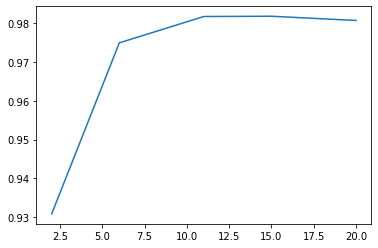

In [22]:
plt.plot(param_grid_bagging_1['n_estimators'],
         clf_bagging_1.cv_results_['mean_test_score'])

In [23]:
best_bagging_1 = clf_bagging_1.best_estimator_
best_bagging_1

BaggingClassifier(n_estimators=15, random_state=42)

In [24]:
y_val_pred_best_bagging_1 = best_bagging_1.predict(X_val)
f2_score(y_val, y_val_pred_best_bagging_1)

0.44999999999999996

# Bagging (2/2)

## Setting up parameter grid and Bagging

In [25]:
n_estimators_bagging_2 = np.unique(np.linspace(12, 19, num=8, dtype=int))
n_estimators_bagging_2

array([12, 13, 15, 17, 19])

In [26]:
param_grid_bagging_2 = {'n_estimators': n_estimators_bagging_2}

In [27]:
bagging_2 = BaggingClassifier(random_state=RANDOM_STATE)
bagging_2

BaggingClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [28]:
clf_bagging_2 = GridSearchCV(bagging_2, param_grid_bagging_2, scoring=f2_scorer)
clf_bagging_2

GridSearchCV(estimator=BaggingClassifier(random_state=42),
             param_grid={'n_estimators': array([12, 13, 15, 17, 19])},
             scoring=make_scorer(fbeta_score, beta=2))

In [29]:
clf_bagging_2.fit(X_train_over, y_train_over)

GridSearchCV(estimator=BaggingClassifier(random_state=42),
             param_grid={'n_estimators': array([12, 13, 15, 17, 19])},
             scoring=make_scorer(fbeta_score, beta=2))

In [30]:
clf_bagging_2.cv_results_

{'mean_fit_time': array([14.02090993, 13.40544806, 15.4781745 , 17.23954382, 19.54143252]),
 'mean_score_time': array([0.0191071 , 0.01815581, 0.01996403, 0.02284799, 0.02508163]),
 'mean_test_score': array([0.97971737, 0.9814722 , 0.98177465, 0.98116987, 0.98127959]),
 'param_n_estimators': masked_array(data=[12, 13, 15, 17, 19],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 12},
  {'n_estimators': 13},
  {'n_estimators': 15},
  {'n_estimators': 17},
  {'n_estimators': 19}],
 'rank_test_score': array([5, 2, 1, 4, 3], dtype=int32),
 'split0_test_score': array([0.96727623, 0.968702  , 0.96752498, 0.96737044, 0.96888804]),
 'split1_test_score': array([0.9808978 , 0.98454493, 0.98512302, 0.98474738, 0.98398169]),
 'split2_test_score': array([0.98431222, 0.98510882, 0.98721862, 0.98626478, 0.98664122]),
 'split3_test_score': array([0.98582104, 0.98716967, 0.98735874, 0.9854434 , 0.98640107]),
 'split

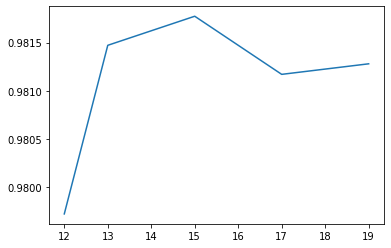

In [31]:
plt.plot(param_grid_bagging_2['n_estimators'],
         clf_bagging_2.cv_results_['mean_test_score'])

In [32]:
best_bagging_2 = clf_bagging_2.best_estimator_
best_bagging_2

BaggingClassifier(n_estimators=15, random_state=42)

In [33]:
y_val_pred_best_bagging_2 = best_bagging_2.predict(X_val)
f2_score(y_val, y_val_pred_best_bagging_2)

0.44999999999999996

# Random forest (1/2)

## Setting up parameter grid and Random forest

In [34]:
n_estimators_rf_1 = np.unique(np.linspace(2, 200, num=10, dtype=int))
n_estimators_rf_1

array([  2,  24,  46,  68,  90, 112, 134, 156, 178, 200])

In [35]:
param_grid_rf_1 = {'n_estimators': n_estimators_rf_1}

In [36]:
rf_1 = RandomForestClassifier(random_state=RANDOM_STATE)
rf_1

RandomForestClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [37]:
clf_rf_1 = GridSearchCV(rf_1, param_grid_rf_1, scoring=f2_scorer)
clf_rf_1

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': array([  2,  24,  46,  68,  90, 112, 134, 156, 178, 200])},
             scoring=make_scorer(fbeta_score, beta=2))

In [38]:
clf_rf_1.fit(X_train_over, y_train_over)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': array([  2,  24,  46,  68,  90, 112, 134, 156, 178, 200])},
             scoring=make_scorer(fbeta_score, beta=2))

In [39]:
clf_rf_1.cv_results_

{'mean_fit_time': array([ 0.15769048,  1.75826979,  3.29823184,  4.88429418,  6.39606996,
         8.28812041, 10.41826978, 11.2285255 , 12.77895374, 14.55406928]),
 'mean_score_time': array([0.00366654, 0.01298823, 0.02178645, 0.03261447, 0.04034662,
        0.04892306, 0.05916882, 0.0687005 , 0.07782249, 0.08671513]),
 'mean_test_score': array([0.92285694, 0.98718192, 0.98826296, 0.98864595, 0.98876359,
        0.98876379, 0.98872574, 0.98853491, 0.98838135, 0.98887919]),
 'param_n_estimators': masked_array(data=[2, 24, 46, 68, 90, 112, 134, 156, 178, 200],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 2},
  {'n_estimators': 24},
  {'n_estimators': 46},
  {'n_estimators': 68},
  {'n_estimators': 90},
  {'n_estimators': 112},
  {'n_estimators': 134},
  {'n_estimators': 156},
  {'n_estimators': 178},
  {'n_estimators': 200}],
 'rank_test_scor

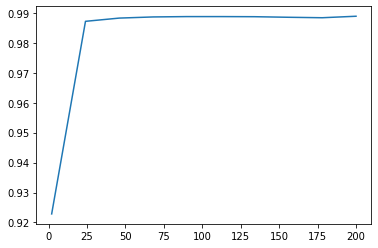

In [40]:
plt.plot(param_grid_rf_1['n_estimators'],
         clf_rf_1.cv_results_['mean_test_score'])

In [41]:
best_rf_1 = clf_rf_1.best_estimator_
best_rf_1

RandomForestClassifier(n_estimators=200, random_state=42)

In [42]:
y_val_pred_best_rf_1 = best_rf_1.predict(X_val)
f2_score(y_val, y_val_pred_best_rf_1)

0.7000000000000001

# Random forest (2/2)

## Setting up parameter grid and Random forest

In [48]:
n_estimators_rf_2 = np.unique(np.linspace(150, 250, num=5, dtype=int))
n_estimators_rf_2

array([150, 175, 200, 225, 250])

In [49]:
param_grid_rf_2 = {'n_estimators': n_estimators_rf_2}

In [50]:
rf_2 = RandomForestClassifier(random_state=RANDOM_STATE)
rf_2

RandomForestClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [51]:
clf_rf_2 = GridSearchCV(rf_2, param_grid_rf_2, scoring=f2_scorer)
clf_rf_2

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': array([150, 175, 200, 225, 250])},
             scoring=make_scorer(fbeta_score, beta=2))

In [52]:
clf_rf_2.fit(X_train_over, y_train_over)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': array([150, 175, 200, 225, 250])},
             scoring=make_scorer(fbeta_score, beta=2))

In [53]:
clf_rf_2.cv_results_

{'mean_fit_time': array([10.37677999, 11.8887219 , 13.77329092, 15.90878015, 18.16220641]),
 'mean_score_time': array([0.06251812, 0.0722652 , 0.08443956, 0.0950686 , 0.1102293 ]),
 'mean_test_score': array([0.9887635 , 0.98861294, 0.98887919, 0.98884354, 0.98911045]),
 'param_n_estimators': masked_array(data=[150, 175, 200, 225, 250],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 150},
  {'n_estimators': 175},
  {'n_estimators': 200},
  {'n_estimators': 225},
  {'n_estimators': 250}],
 'rank_test_score': array([4, 5, 2, 3, 1], dtype=int32),
 'split0_test_score': array([0.98909508, 0.98832759, 0.98832759, 0.98909508, 0.98928435]),
 'split1_test_score': array([0.98837209, 0.98761905, 0.98799543, 0.98799543, 0.98837209]),
 'split2_test_score': array([0.98931502, 0.98931502, 0.98950382, 0.98931502, 0.98950382]),
 'split3_test_score': array([0.9894636 , 0.98965319, 0.9894636 , 0.98908464, 0.99004213]

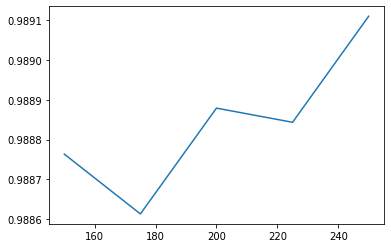

In [54]:
plt.plot(param_grid_rf_2['n_estimators'],
         clf_rf_2.cv_results_['mean_test_score'])

In [55]:
best_rf_2 = clf_rf_2.best_estimator_
best_rf_2

RandomForestClassifier(n_estimators=250, random_state=42)

In [56]:
y_val_pred_best_rf_2 = best_rf_2.predict(X_val)
f2_score(y_val, y_val_pred_best_rf_2)

0.6565656565656566

# AdaBoost (1/3)

## Setting up parameter grid and AdaBoost

In [71]:
n_estimators_ada_1 = np.unique(np.linspace(2, 100, num=10, dtype=int))
n_estimators_ada_1

array([  2,  12,  23,  34,  45,  56,  67,  78,  89, 100])

In [72]:
param_grid_ada_1 = {'n_estimators': n_estimators_ada_1}

In [73]:
ada_1 = AdaBoostClassifier(random_state=RANDOM_STATE)
ada_1

AdaBoostClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [74]:
clf_ada_1 = GridSearchCV(ada_1, param_grid_ada_1, scoring=f2_scorer)
clf_ada_1

GridSearchCV(estimator=AdaBoostClassifier(random_state=42),
             param_grid={'n_estimators': array([  2,  12,  23,  34,  45,  56,  67,  78,  89, 100])},
             scoring=make_scorer(fbeta_score, beta=2))

In [75]:
clf_ada_1.fit(X_train_over_rspl, y_train_over_rspl)

GridSearchCV(estimator=AdaBoostClassifier(random_state=42),
             param_grid={'n_estimators': array([  2,  12,  23,  34,  45,  56,  67,  78,  89, 100])},
             scoring=make_scorer(fbeta_score, beta=2))

In [76]:
clf_ada_1.cv_results_

{'mean_fit_time': array([0.14674621, 0.8282105 , 1.55488782, 2.32502308, 3.05944715,
        3.74229059, 4.54626069, 5.33550968, 6.0586473 , 6.90639992]),
 'mean_score_time': array([0.00312953, 0.01067395, 0.01669011, 0.02419562, 0.03444996,
        0.03890047, 0.04895115, 0.05366459, 0.06159306, 0.06731415]),
 'mean_test_score': array([0.35731226, 0.33332915, 0.35084244, 0.36750986, 0.40043237,
        0.45146084, 0.46392423, 0.54313469, 0.54756848, 0.60253107]),
 'param_n_estimators': masked_array(data=[2, 12, 23, 34, 45, 56, 67, 78, 89, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 2},
  {'n_estimators': 12},
  {'n_estimators': 23},
  {'n_estimators': 34},
  {'n_estimators': 45},
  {'n_estimators': 56},
  {'n_estimators': 67},
  {'n_estimators': 78},
  {'n_estimators': 89},
  {'n_estimators': 100}],
 'rank_test_score': array([ 8, 10,

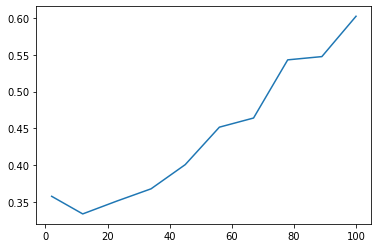

In [77]:
plt.plot(param_grid_ada_1['n_estimators'],
         clf_ada_1.cv_results_['mean_test_score'])

In [78]:
best_ada_1 = clf_ada_1.best_estimator_
best_ada_1

AdaBoostClassifier(n_estimators=100, random_state=42)

In [79]:
y_val_pred_best_ada_1 = best_ada_1.predict(X_val)
f2_score(y_val, y_val_pred_best_ada_1)

0.3260869565217391

# AdaBoost (2/3)

## Setting up parameter grid and AdaBoost

In [80]:
n_estimators_ada_2 = np.unique(np.linspace(101, 200, num=10, dtype=int))
n_estimators_ada_2

array([101, 112, 123, 134, 145, 156, 167, 178, 189, 200])

In [81]:
param_grid_ada_2 = {'n_estimators': n_estimators_ada_2}

In [82]:
ada_2 = AdaBoostClassifier(random_state=RANDOM_STATE)
ada_2

AdaBoostClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [83]:
clf_ada_2 = GridSearchCV(ada_2, param_grid_ada_2, scoring=f2_scorer)
clf_ada_2

GridSearchCV(estimator=AdaBoostClassifier(random_state=42),
             param_grid={'n_estimators': array([101, 112, 123, 134, 145, 156, 167, 178, 189, 200])},
             scoring=make_scorer(fbeta_score, beta=2))

In [84]:
clf_ada_2.fit(X_train_over_rspl, y_train_over_rspl)

GridSearchCV(estimator=AdaBoostClassifier(random_state=42),
             param_grid={'n_estimators': array([101, 112, 123, 134, 145, 156, 167, 178, 189, 200])},
             scoring=make_scorer(fbeta_score, beta=2))

In [85]:
clf_ada_2.cv_results_

{'mean_fit_time': array([ 6.35158935,  6.78442702,  7.73636065,  8.91081448,  9.04052939,
         9.61237869, 10.43931723, 11.88751564, 11.77308412, 13.47821956]),
 'mean_score_time': array([0.06616607, 0.07197318, 0.08119688, 0.08836865, 0.09658771,
        0.1022356 , 0.11028976, 0.12612748, 0.12678642, 0.13884764]),
 'mean_test_score': array([0.59469414, 0.63799859, 0.66652144, 0.67540857, 0.70268488,
        0.74706448, 0.75163291, 0.76184866, 0.77669873, 0.78727901]),
 'param_n_estimators': masked_array(data=[101, 112, 123, 134, 145, 156, 167, 178, 189, 200],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 101},
  {'n_estimators': 112},
  {'n_estimators': 123},
  {'n_estimators': 134},
  {'n_estimators': 145},
  {'n_estimators': 156},
  {'n_estimators': 167},
  {'n_estimators': 178},
  {'n_estimators': 189},
  {'n_estimators': 200}],
 'ra

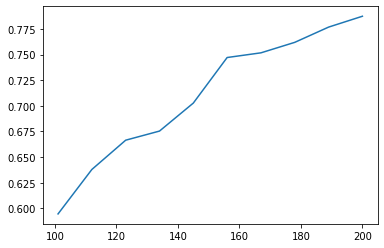

In [86]:
plt.plot(param_grid_ada_2['n_estimators'],
         clf_ada_2.cv_results_['mean_test_score'])

In [87]:
best_ada_2 = clf_ada_2.best_estimator_
best_ada_2

AdaBoostClassifier(n_estimators=200, random_state=42)

In [88]:
y_val_pred_best_ada_2 = best_ada_2.predict(X_val)
f2_score(y_val, y_val_pred_best_ada_2)

0.3804347826086957

# AdaBoost (3/3)

## Setting up parameter grid and AdaBoost

In [89]:
n_estimators_ada_3 = np.unique(np.linspace(201, 400, num=10, dtype=int))
n_estimators_ada_3

array([201, 223, 245, 267, 289, 311, 333, 355, 377, 400])

In [90]:
param_grid_ada_3 = {'n_estimators': n_estimators_ada_3}

In [91]:
ada_3 = AdaBoostClassifier(random_state=RANDOM_STATE)
ada_3

AdaBoostClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [92]:
clf_ada_3 = GridSearchCV(ada_3, param_grid_ada_3, scoring=f2_scorer)
clf_ada_3

GridSearchCV(estimator=AdaBoostClassifier(random_state=42),
             param_grid={'n_estimators': array([201, 223, 245, 267, 289, 311, 333, 355, 377, 400])},
             scoring=make_scorer(fbeta_score, beta=2))

In [93]:
clf_ada_3.fit(X_train_over_rspl, y_train_over_rspl)

GridSearchCV(estimator=AdaBoostClassifier(random_state=42),
             param_grid={'n_estimators': array([201, 223, 245, 267, 289, 311, 333, 355, 377, 400])},
             scoring=make_scorer(fbeta_score, beta=2))

In [94]:
clf_ada_3.cv_results_

{'mean_fit_time': array([19.71797743, 24.40891261, 19.1383255 , 18.56815715, 19.92536016,
        21.4492146 , 23.18513923, 24.98176532, 26.36258187, 27.80951138]),
 'mean_score_time': array([0.22996273, 0.24801331, 0.19583397, 0.19513206, 0.1980505 ,
        0.22007155, 0.2381659 , 0.25005732, 0.2852941 , 0.28138909]),
 'mean_test_score': array([0.77618307, 0.79730895, 0.7987771 , 0.79393193, 0.80203291,
        0.79651687, 0.78737254, 0.79364748, 0.78683482, 0.79312294]),
 'param_n_estimators': masked_array(data=[201, 223, 245, 267, 289, 311, 333, 355, 377, 400],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 201},
  {'n_estimators': 223},
  {'n_estimators': 245},
  {'n_estimators': 267},
  {'n_estimators': 289},
  {'n_estimators': 311},
  {'n_estimators': 333},
  {'n_estimators': 355},
  {'n_estimators': 377},
  {'n_estimators': 400}],
 'ra

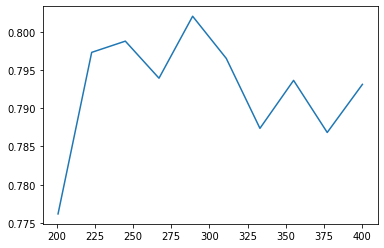

In [95]:
plt.plot(param_grid_ada_3['n_estimators'],
         clf_ada_3.cv_results_['mean_test_score'])

In [96]:
best_ada_3 = clf_ada_3.best_estimator_
best_ada_3

AdaBoostClassifier(n_estimators=289, random_state=42)

In [97]:
y_val_pred_best_ada_3 = best_ada_3.predict(X_val)
f2_score(y_val, y_val_pred_best_ada_3)

0.2808988764044944